In [1]:
## math, plotting
import matplotlib.pyplot as plt
import seaborn as sb

import numpy as np
import pandas as pd
import scipy.stats
import statsmodels.api as sm
from statsmodels.formula.api import ols


## machine learning
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression


import pickle

import sys
from os import listdir
user = 'will'
if user != 'will':
    sys.path.append('../../Beltway_Project/')
    sys.path.append('../../RatterdamOpen_Project/')
    sys.path.append('../DATA/')
    sys.path.append('../../../ratterdam/')
    from statannot import add_stat_annotation



import RateMapClass_William_20190308 as RateMapClass
import ratterdam_RepetitionCoreFx as CoreFx
import confounds as direction
import newAlleyBounds as bounds2
import repetition_manuscript_defaults as MDef 

R765_RFD5
R765_DFD4
R781_D3
R781_D4
R808_D6
R808_D7
R859_D1
R859_D2
R886_D1
R886_D2


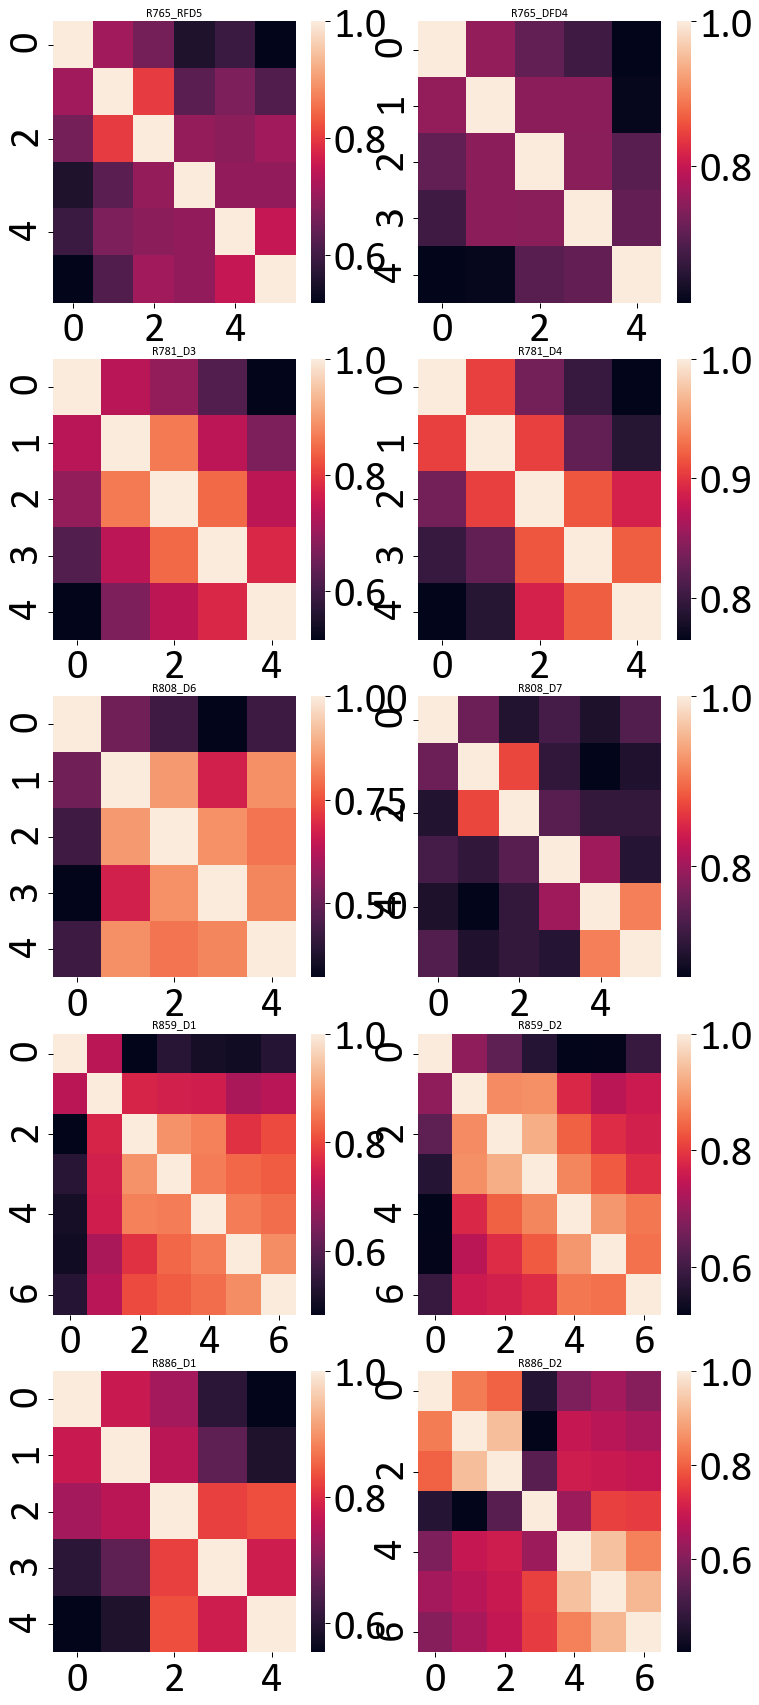

In [2]:
## Changes in representation with time
## Population vector correlation heatmaps
## x and y axis - time windows

rep_nonrep = 'both' ## 'rep', 'nonrep', 'both' are options

## Reading in file with all data
if user != 'will':
    file = open('../DATA/20220405-124315_superPopulationRepetition.pickle','rb')
    alldat = pickle.load(file)
    store_dir = '../DATA/FILES/'
elif user == 'will':
    with open("E:\\Ratterdam\\R_data_repetition\\20220405-124315_superPopulationRepetition.pickle","rb") as f:
        alldat = pickle.load(f)  
    store_dir = 'E:\\Ratterdam\\repetition_manuscript\\Figure6_TemporalDynamics\\MN_analyses\\FILES\\'


interneuron_thresh = 0.03 ##0.08
interneuron_num_alleys = 17
all_delta_corr = [[],[],[],[],[],[],[]]
fig, axs = plt.subplots(5,2, figsize = (12,30))
num_cells = []
all_rats = list(alldat.keys())
figy = 0
for rat in all_rats:
    all_days = list(alldat[rat].keys())
    figx = 0
    for day in all_days:
        day_neur = rat + '_' + day
        print(day_neur)
        anorm = np.load(store_dir + rat + '_' + day + '_time_alley_neur_normalized_.npy')
        anorm[anorm == np.inf] = np.NaN
        
        repeating_cells = []
        all_cells = alldat[rat][day]['units'].keys()
        for each_cell in all_cells:
            data = alldat[rat][day]['units'][each_cell]
            if data.repeating == True:
                repeating_cells.append(True)
            else:
                repeating_cells.append(False)
        
        if rep_nonrep == 'rep':
            anorm = anorm[:,:, repeating_cells]
        elif rep_nonrep == 'nonrep':
            anorm = anorm[:,:, ~np.array(repeating_cells)]
       
        
        ## excluding interneurons
        exclude_only = np.nanmean(anorm, axis = (0,1))> interneuron_thresh
        exclude_only= exclude_only*(np.sum(np.nanmean(anorm, axis = 0)>interneuron_thresh, axis = 0)>interneuron_num_alleys)
        include_only = ~exclude_only
        anorm = anorm[:,:, include_only]
        
        if np.shape(anorm)[2]!=0:
            corr_plot = np.zeros((len(anorm), len(anorm)))
            for i in range(0, len(anorm)):
                for j in range(0, len(anorm)):
                    if True not in np.isnan(anorm[i]) and True not in np.isnan(anorm[j]) and i!=j:
                        corr_plot[i,j] = scipy.stats.pearsonr(anorm[i].flatten(),anorm[j].flatten())[0]
                        if i>=j:
                            all_delta_corr[abs(i-j)].append(corr_plot[i,j])
                    else:
                        no_na_i = ~np.isnan(anorm[i].flatten())
                        no_na_j = ~np.isnan(anorm[j].flatten())
                        no_na = no_na_i*no_na_j
                        corr_plot[i,j] = scipy.stats.pearsonr(anorm[i].flatten()[no_na],anorm[j].flatten()[no_na])[0]
                        if i>=j:
                            all_delta_corr[abs(i-j)].append(corr_plot[i,j])
            sb.heatmap(corr_plot, ax = axs[figy, figx])
            axs[figy, figx].set_title(rat + '_' + day)
            ##plt.show()
            figx = figx + 1
    figy = figy + 1

In [3]:
## plots a single figure showing drop in population-vector correlation with increasing time difference
%matplotlib qt5

df_corr = pd.DataFrame(np.array([np.ones(len(all_delta_corr[1])),np.array(all_delta_corr[1])]).T, columns = ['time', 'correlation'])
for j in range(2, len(all_delta_corr)):
    df_new = pd.DataFrame(np.array([j*np.ones(len(all_delta_corr[j])),np.array(all_delta_corr[j])]).T, columns = ['time', 'correlation'])
    df_corr = df_corr.append(df_new, ignore_index = True)

    
res = scipy.stats.linregress(df_corr)
print(f"R-squared: {res.rvalue**2}")
print(f"pvalue: {res.pvalue}")
print(f"slope: {res.slope}")

fig, ax = plt.subplots()
boxes = ax.boxplot(all_delta_corr[1:],
            notch=True,
            patch_artist=True
            )

for patch in boxes['boxes']:
    patch.set_facecolor('gray')
    patch.set_edgecolor('black')
    patch.set_linewidth(2)

ax.set_xticklabels(np.arange(1, len(all_delta_corr)))
ax.plot(np.arange(1, 7, 1), res.intercept + res.slope*np.arange(1, 7, 1), '-ro', label='fitted line')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.tick_params(axis='both', labelsize=MDef.ticksize)
ax.set_ylabel("Population Vector Correltion", fontsize=MDef.ylabelsize)
ax.set_xlabel("Time Delta (number of windows)",fontsize=MDef.ylabelsize)
plt.show()

R-squared: 0.2767994549560799
pvalue: 1.4983494993251445e-11
slope: -0.049639109262582914


In [5]:
## statistic one way anova
print(scipy.stats.f_oneway(all_delta_corr[1],all_delta_corr[2],all_delta_corr[3], all_delta_corr[4], all_delta_corr[5], all_delta_corr[6]))

# Ordinary Least Squares (OLS) model
model = ols('correlation ~ C(time)', data=df_corr).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table


F_onewayResult(statistic=11.2685639991915, pvalue=4.101165266138491e-09)


,sum_sq,df,F,PR(>F)
C(time),0.646176,5.0,11.268564,4.101165e-09
Residual,1.571206,137.0,NaN,NaN


In [31]:
from scipy.stats import binom_test
print(binom_test(8,10, 0.5, 'greater'))

0.054687500000000014
